# Find the Lane Lines on road
#### We identify the lane lines by using color
#### White color is [255, 255, 255] in [R,G,B] notation

## Import the packages necessary

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## L2-3 Color Selection

### Read image from the assets using matplotlib

In [4]:
image = mpimg.imread('assets/imageL2-3.jpg')
print('This image is:', type(image), ' with dimensions: ', image.shape)

This image is: <class 'numpy.ndarray'>  with dimensions:  (540, 960, 3)


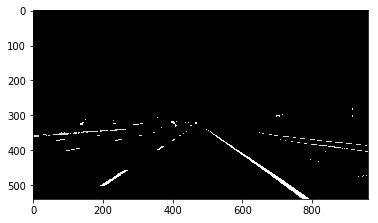

In [8]:
# make a copy of the image to work on rather than
# working on the original image.
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

# define a rgb_threshold.
red_threshold = 200
blue_threshold = 200
green_threshold = 200
rgb_threshold = [red_threshold, blue_threshold, green_threshold]

# filter the original image with the given rgb_values and
# set values below threshold to black[0,0,0].
thresholds = (image[:,:,0] < rgb_threshold[0]) | (image[:,:,1] < rgb_threshold[1]) | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0, 0, 0]

# Display the filtered image
plt.imshow(color_select)
plt.show()

## L2-5 Region Of Interest

### Triangular region of interest from the bottom of image.

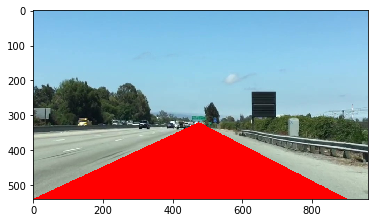

In [31]:
region_select = np.copy(image)

# Define a triangular region of interest
# In image processing, (0, 0) is the top left corner of the image
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

# fit lines (y=Ax+B) to find the triangular region
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# find the region inside the triangle
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & (YY > (XX*fit_right[0] + fit_right[1])) & (YY < (XX*fit_bottom[0] + fit_bottom[1]))

# color the pixels which are inside the R.O.I
region_select[region_thresholds] = [255, 0, 0] #red

# Display the mask
plt.imshow(region_select)
plt.show()

## L2-6 Combine both color and ROI

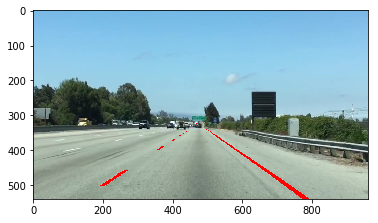

In [32]:
line_image = np.copy(image)

# Find out where the image is colored right and in the region
line_image[~thresholds & region_thresholds] = [255, 0, 0]

plt.imshow(color_select)
plt.imshow(line_image)
plt.show()

## L2-11 Canny Edge Detection
To Find the lane lines of any color, we need to first detect the edges
To find the edges,
1. To easily find the edges, we will first GrayScale the image
2. Then we will apply a Blur method to reduce the noise
3. And finally apply the `Canny` method that from OpenCV

In [33]:
import cv2

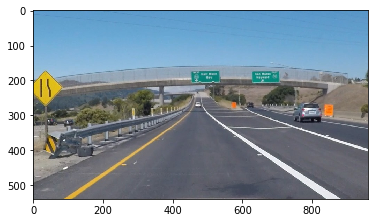

In [34]:
image = mpimg.imread('assets/imageL2-11.jpg')

plt.imshow(image)
plt.show()

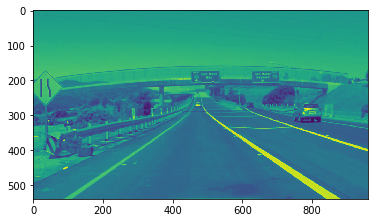

In [37]:
img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(img_gray)
plt.show()

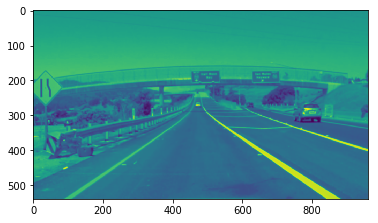

In [46]:
# apply gaussian blur to the image
kernel_size = 5
img_blur = cv2.GaussianBlur(img_gray, (kernel_size, kernel_size), 0)

plt.imshow(img_blur)
plt.show()

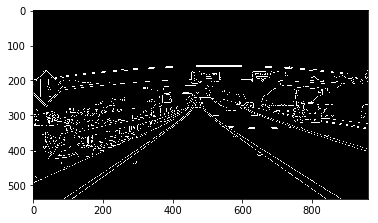

In [56]:
# Apply Canny edge detection with suitable parameter
low_threshold = 50
high_threshold = 150
img_edges = cv2.Canny(img_blur, low_threshold, high_threshold)

plt.imshow(img_edges, cmap='Greys_r')
plt.show()

# L2-14 Hough Transform to Find Lines
Find the lines in the edge detected image using the hough transform provided by cv2

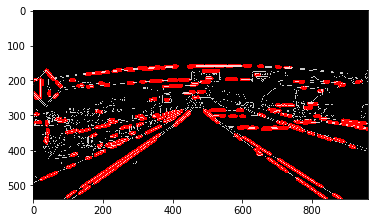

In [58]:
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1
line_image = np.copy(image)*0

# Run Hough on edge detected image
lines = cv2.HoughLinesP(img_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the line_image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((img_edges, img_edges, img_edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

plt.imshow(combo)
plt.show()

## L2-15 Detect Lines in the R.O.I
Create a masked image and then apply the hough transform.

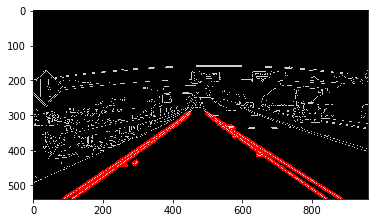

In [61]:
img = mpimg.imread('assets/imageL2-11.jpg')

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

kernel_size = 5
img_blur = cv2.GaussianBlur(img_gray, (kernel_size, kernel_size), 0)

low_threshold = 50
high_threshold = 150
img_edge = cv2.Canny(img_blur, low_threshold, high_threshold)

# Create a mask
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
img_mask = cv2.bitwise_and(edges, mask)

rho = 1
thetha = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1
img_line = np.copy(image)*0

lines = cv2.HoughLinesP(img_mask, rho, thetha, threshold, min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(img_line, (x1, y1), (x2, y2), (255, 0, 0), 10)
        
img_color_edges = np.dstack((img_edges, img_edges, img_edges))

img_line_edges = cv2.addWeighted(img_color_edges, 0.8, img_line, 1, 0)

plt.imshow(img_line_edges)
plt.show()

# Move on to the project....